#### Custering Face Images using k-means and tSNE <br>
In this notebook we will [cluster](https://en.wikipedia.org/wiki/Cluster_analysis) images using [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) clustering algorithm and visualize the clusters using [t-SNE](https://lvdmaaten.github.io/tsne/). The dataset we will use is a simple [face dataset](https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset) which contains face images of 5 different persons. <br>
The pipeline of our approach will be as follows: <br>

1.   Load Images
2.   Exract features using a pre-trained model
3.   Use K-means clustering to cluster images based on the feature similarity
4.   Use t-SNE to visualize the clusters.




First let's import all the necessary libraries.

In [2]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
from tqdm import tqdm

%matplotlib inline

Load the pretrained VGG16 model and remove the output layers because we only need the features of each image to do the clustering based on them.

In [4]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##### Loading data and extracting features: <br>
In the following block of code, we will load images from each directory of persons and extract their features using the pretrained VGG16 model. The features will be saved in a list for clustering using k-means. We will be resizing the images to 224 x 224 because the VGG16 model is trained on images of size 224 x 224.

We will not care about the image labels because clustering is an unsupervised learning method.

In [6]:
data_dir = '5-celebrity-faces-dataset/data/train/'

img_features = []

class_dirs = os.listdir(data_dir)

for direc in class_dirs:
  print('\nextracting image features from ', direc)
  class_dir = os.path.join(data_dir, direc)
  for imagepath in tqdm(list(paths.list_images(class_dir))):
    # load image
    img = load_img(imagepath, target_size=(224, 224))
    
    # preprocess to feed to the model
    img = np.array(img)
    reshaped_img = img.reshape(1,224,224,3)
    x = preprocess_input(reshaped_img)
    
    # extract features
    feat = model.predict(x)

    # append to the list of image features
    img_features.append(feat)

# convert the features to array type
img_features = np.array(img_features)

  0%|          | 0/14 [00:00<?, ?it/s]


extracting image features from  ben_afflek


  0%|          | 0/17 [00:00<?, ?it/s]


extracting image features from  elton_john


  0%|          | 0/21 [00:00<?, ?it/s]


extracting image features from  jerry_seinfeld


  0%|          | 0/19 [00:00<?, ?it/s]


extracting image features from  madonna


  0%|          | 0/22 [00:00<?, ?it/s]


extracting image features from  mindy_kaling


100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


In [7]:
img_features.shape

(93, 1, 4096)

KMeans algorithm requires data to be in the shape of (n_samples, n_features), so we will convert the img_features vector to two dimension.

In [8]:
img_features = img_features.reshape(-1, 4096)

In [9]:
img_features.shape

(93, 4096)

##### Elbow method for determining the number of clusters: <br>
Now that we have features in the required shape, we need to know how many clusters do we need to make for our data. In our case we know there should be 5 clusters because of 5 different persons but we will use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to find how many clusters should there be according to the features similarity. We will check for 1 to 10 clusters and get the optimal number of clusters.

In [11]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, init='random', random_state=22)
  kmeans.fit(img_features)
  sse.append(kmeans.inertia_)

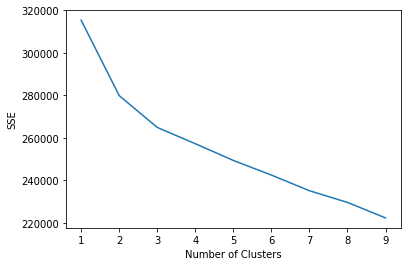

In [12]:
plt.plot(range(1, 10), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

It is not easy to look from the plot where the elbow lies. So, we will use a library (`kneed`) to locate the elbow point. The following code will give us the elbow point which is the optimal number of clusters for our data.



```
# for colab install the library using the following command in notebook
# if working on local system, run the command in terminal without the exclamation mark
! pip install kneed
```



In [13]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 10), sse, curve="convex", direction="decreasing"
)

In [14]:
num_clusters = kl.elbow
num_clusters

3

Now, we will cluster the data with the number of clusters that we got in the above step, i.e. `num_clusters`.

In [15]:
kmeans = KMeans(n_clusters=num_clusters, init='random', random_state=22)

In [16]:
# compute k-means clustering
kmeans.fit(img_features)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=22,
       tol=0.0001, verbose=0)

In [17]:
# number of iterations required to converge
kmeans.n_iter_

5

The kmeans algorithm will group the features into `num_clusters` clusters and will give a label to each cluster from `0` to `num_clusters - 1`. We can see below:

In [18]:
labels = kmeans.labels_

In [19]:
labels

array([2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)

#### Visualize the clusters using tSNE <br>
Now we will use t-sne to look at the grouping of the features done by k-means clustering. The following code will project our feature vector of (n_samples, n_features) to (n_samples, n_components). Because we want to visualize the data in 2D, we will use `n_components = 2`.

In [20]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(img_features)

In [21]:
tsne.shape

(93, 2)

In [22]:
# extract x and y coordinates representing the positions 
# of the features on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

In [23]:
palette = sns.color_palette("bright", num_clusters)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


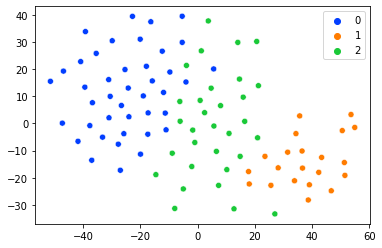

In [24]:
sns.scatterplot(tx, ty, hue=labels, legend='full', palette=palette)

The above plot shows that the clusters are not clearly distinguishable. The possible reasons are that the features are not good enough to distinguish faces from each other. We can learn a good feature extractor specific to our dataset and employ that for clustering. Also, the resolution of images are low, so upscaling them to 224 x 224 may resulted in loss of information.<br>

We had 5 different faces but got the optimal number of clusters to be 3. That's again the features are not strong enough to distinguish between each face. So, we may improve this in future.

#### References <br>
* [t-SNE for Feature Visualization](https://learnopencv.com/t-sne-for-feature-visualization/)
* [K-Means Clustering in Python: A Practical Guide](https://realpython.com/k-means-clustering-python/#how-to-perform-k-means-clustering-in-python)
* [How to cluster images based on visual similarity](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34)